# 多尺度目标检测

在[“锚框”](anchor.ipynb)一节中，我们在实验中以输入图像的每个像素为中心生成多个锚框。这些锚框是对输入图像不同区域的采样。然而，如果以图像每个像素为中心都生成锚框，很容易生成过多锚框而造成计算量过大。举个例子，假设输入图像的高和宽分别为561像素和728像素，如果以每个像素为中心生成5个不同形状的锚框，那么一张图像上则需要标注并预测200多万个锚框（$561 \times 728 \times 5$）。

减少锚框个数并不难。一种简单的方法是在输入图像中均匀采样一小部分像素，并以采样的像素为中心生成锚框。此外，在不同尺度下，我们可以生成不同数量和不同大小的锚框。值得注意的是，较小目标比较大目标在图像上出现位置的可能性更多。举个简单的例子：形状为$1 \times 1$、$1 \times 2$和$2 \times 2$的目标在形状为$2 \times 2$的图像上可能出现的位置分别有4、2和1种。因此，当使用较小锚框来检测较小目标时，我们可以采样较多的区域；而当使用较大锚框来检测较大目标时，我们可以采样较少的区域。

为了演示如何多尺度生成锚框，我们先读取一张图像。它的高和宽分别为561像素和728像素。

In [19]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

img = tf.keras.preprocessing.image.load_img('catdog.jpg')
h, w = img.size[0:2]
h, w

(322, 252)

我们在[“二维卷积层”](../chapter_convolutional-neural-networks/conv-layer.ipynb)一节中将卷积神经网络的二维数组输出称为特征图。
我们可以通过定义特征图的形状来确定任一图像上均匀采样的锚框中心。

下面定义`display_anchors`函数。我们在特征图`fmap`上以每个单元（像素）为中心生成锚框`anchors`。由于锚框`anchors`中$x$和$y$轴的坐标值分别已除以特征图`fmap`的宽和高，这些值域在0和1之间的值表达了锚框在特征图中的相对位置。由于锚框`anchors`的中心遍布特征图`fmap`上的所有单元，`anchors`的中心在任一图像的空间相对位置一定是均匀分布的。具体来说，当特征图的宽和高分别设为`fmap_w`和`fmap_h`时，该函数将在任一图像上均匀采样`fmap_h`行`fmap_w`列个像素，并分别以它们为中心生成大小为`s`（假设列表`s`长度为1）的不同宽高比（`ratios`）的锚框。

In [31]:
def display_anchors(fmap_w, fmap_h, s):
    fmap = np.zeros((1, 10, fmap_w, fmap_h))  # 前两维的取值不影响输出结果
    anchors = MultiBoxPrior(fmap, sizes=s, ratios=[1, 2, 0.5])
    offset_x, offset_y = 1.0/fmap_w, 1.0/fmap_h
    anchors += tf.constant([offset_x/2, offset_y/2, offset_x/2, offset_y/2])
    bbox_scale = np.array((w, h, w, h))
    show_bboxes(plt.imshow(img).axes,
                    anchors[0] * bbox_scale)
    
def MultiBoxPrior(feature_map, sizes=[0.75, 0.5, 0.25], ratios=[1, 2, 0.5]):
    """
    Args:
        feature_map: torch tensor, Shape: [N, C, H, W].
        sizes: List of sizes (0~1) of generated MultiBoxPriores. 
        ratios: List of aspect ratios (non-negative) of generated MultiBoxPriores. 
    Returns:
        anchors of shape (1, num_anchors, 4).
    """
    pairs = [] # pair of (size, sqrt(ratio))
    for r in ratios:
        pairs.append([sizes[0], np.sqrt(r)])
    for s in sizes[1:]:
        pairs.append([s, np.sqrt(ratios[0])])
    
    pairs = np.array(pairs)

    ss1 = pairs[:, 0] * pairs[:, 1] # size * sqrt(ration)
    ss2 = pairs[:, 0] / pairs[:, 1] # size / sqrt(retion)

    base_anchors = tf.stack([-ss1, -ss2, ss1, ss2], axis=1) / 2

    h, w = feature_map.shape[-2:]
    shifts_x = tf.divide(tf.range(0, w), w)
    shifts_y = tf.divide(tf.range(0, h), h)
    shift_x, shift_y = tf.meshgrid(shifts_x, shifts_y)
    shift_x = tf.reshape(shift_x, (-1,))
    shift_y = tf.reshape(shift_y, (-1,))
    shifts = tf.stack((shift_x, shift_y, shift_x, shift_y), axis=1)

    anchors = tf.add(tf.reshape(shifts, (-1,1,4)), tf.reshape(base_anchors, (1,-1,4)))
    return tf.cast(tf.reshape(anchors, (1,-1,4)), tf.float32)

def show_bboxes(axes, bboxes, labels=None, colors=None):
    def _make_list(obj, default_values=None):
        if obj is None:
            obj = default_values
        elif not isinstance(obj, (list, tuple)):
            obj = [obj]
        return obj
    
    labels = _make_list(labels)
    colors = _make_list(colors, ['b', 'g', 'r', 'm', 'c'])
    for i, bbox in enumerate(bboxes):
        color = colors[i % len(colors)]
        rect = bbox_to_rect(bbox.numpy(), color)
        axes.add_patch(rect)
        if labels and len(labels) > i:
            text_color = 'k' if color == 'w' else 'w'
            axes.text(rect.xy[0], rect.xy[1], labels[i],
                va='center', ha='center', fontsize=6,
                color=text_color, bbox=dict(facecolor=color, lw=0))
            
def bbox_to_rect(bbox, color):
    return plt.Rectangle(
        xy=(bbox[0], bbox[1]), width=bbox[2]-bbox[0], height=bbox[3]-bbox[1],
        fill=False, edgecolor=color, linewidth=2)

x = tf.zeros((1,3,h,w))
y = MultiBoxPrior(x)
y.shape

TensorShape([1, 405720, 4])

我们先关注小目标的检测。为了在显示时更容易分辨，这里令不同中心的锚框不重合：设锚框大小为0.15，特征图的高和宽分别为4。可以看出，图像上4行4列的锚框中心分布均匀。

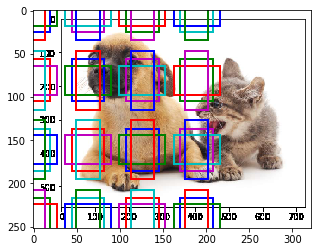

In [32]:
display_anchors(fmap_w=4, fmap_h=4, s=[0.15])

我们将特征图的高和宽分别减半，并用更大的锚框检测更大的目标。当锚框大小设0.4时，有些锚框的区域有重合。

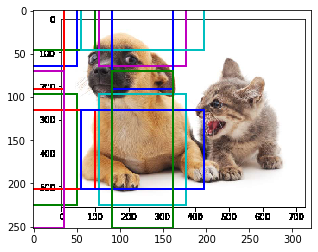

In [33]:
display_anchors(fmap_w=2, fmap_h=2, s=[0.4])

最后，我们将特征图的高和宽进一步减半至1，并将锚框大小增至0.8。此时锚框中心即图像中心。

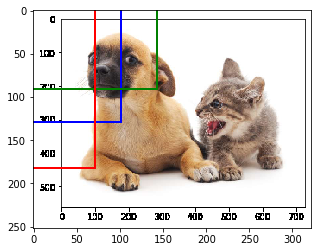

In [34]:
display_anchors(fmap_w=1, fmap_h=1, s=[0.8])

既然我们已在多个尺度上生成了不同大小的锚框，相应地，我们需要在不同尺度下检测不同大小的目标。下面我们来介绍一种基于卷积神经网络的方法。

在某个尺度下，假设我们依据$c_i$张形状为$h \times w$的特征图生成$h \times w$组不同中心的锚框，且每组的锚框个数为$a$。例如，在刚才实验的第一个尺度下，我们依据10（通道数）张形状为$4 \times 4$的特征图生成了16组不同中心的锚框，且每组含3个锚框。
接下来，依据真实边界框的类别和位置，每个锚框将被标注类别和偏移量。在当前的尺度下，目标检测模型需要根据输入图像预测$h \times w$组不同中心的锚框的类别和偏移量。

假设这里的$c_i$张特征图为卷积神经网络根据输入图像做前向计算所得的中间输出。既然每张特征图上都有$h \times w$个不同的空间位置，那么相同空间位置可以看作含有$c_i$个单元。
根据[“二维卷积层”](../chapter_convolutional-neural-networks/conv-layer.ipynb)一节中感受野的定义，特征图在相同空间位置的$c_i$个单元在输入图像上的感受野相同，并表征了同一感受野内的输入图像信息。
因此，我们可以将特征图在相同空间位置的$c_i$个单元变换为以该位置为中心生成的$a$个锚框的类别和偏移量。
不难发现，本质上，我们用输入图像在某个感受野区域内的信息来预测输入图像上与该区域位置相近的锚框的类别和偏移量。

当不同层的特征图在输入图像上分别拥有不同大小的感受野时，它们将分别用来检测不同大小的目标。例如，我们可以通过设计网络，令较接近输出层的特征图中每个单元拥有更广阔的感受野，从而检测输入图像中更大尺寸的目标。

我们将在[“单发多框检测（SSD）”](ssd.ipynb)一节具体实现一个多尺度目标检测的模型。


## 小结

* 可以在多个尺度下生成不同数量和不同大小的锚框，从而在多个尺度下检测不同大小的目标。
* 特征图的形状能确定任一图像上均匀采样的锚框中心。
* 用输入图像在某个感受野区域内的信息来预测输入图像上与该区域相近的锚框的类别和偏移量。